In [1]:
# B0 — Imports & Config (Projeto Telehealth BR • SIA/SUS)
import os, io, glob, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["figure.dpi"] = 110

# >>> Ajuste aqui se precisar:
PATH = r"C:\Users\pedro\OneDrive\Área de Trabalho\2GS2025\IA-CHALL\DATASET-BRASIL-SUS.csv"
OUTDIR = "./outputs"
os.makedirs(OUTDIR, exist_ok=True)


In [25]:
# B1 (robusto) — Lê arquivo do TABNET mesmo quando foi salvo como HTML
import re, io
from html import unescape

PATH = r"C:\Users\pedro\OneDrive\Área de Trabalho\2GS2025\IA-CHALL\DATASET-BRASIL-SUS.csv"

def load_tabnet_any(path):
    with open(path, "r", encoding="latin1", errors="ignore") as f:
        text = f.read()

    def _clean_cols(cols):
        return (pd.Index(cols).astype(str)
                .str.replace(r"<.*?>", "", regex=True)
                .str.replace('"', "")
                .str.strip())

    if "<html" in text.lower():
        # 1) Se “Colunas separadas por ‘;’”, os dados ficam entre <pre>...</pre>
        pres = re.findall(r"<pre[^>]*>(.*?)</pre>", text, flags=re.I|re.S)
        if pres:
            data = max(pres, key=len)
            data = unescape(re.sub(r"<.*?>", "", data))  # remove tags internas e decodifica &nbsp;
            df_wide = pd.read_csv(io.StringIO(data), sep=";", engine="python", encoding="latin1")
            df_wide.columns = _clean_cols(df_wide.columns)
        else:
            # 2) Se “Tabela com bordas”, parseia as tabelas HTML
            # (não depende de lxml/bs4)
            # Converte as <td> e <th> para texto plano com separador ';'
            table = re.search(r"<table[^>]*>(.*?)</table>", text, flags=re.I|re.S)
            assert table, "Não encontrei <table> no HTML salvo."
            raw = table.group(1)

            # extrai linhas e células
            rows = re.findall(r"<tr[^>]*>(.*?)</tr>", raw, flags=re.I|re.S)
            parsed = []
            for row in rows:
                cells = re.findall(r"<t[dh][^>]*>(.*?)</t[dh]>", row, flags=re.I|re.S)
                cells = [unescape(re.sub(r"<.*?>","", c)).strip() for c in cells]
                if cells: parsed.append(cells)

            # primeira linha = cabeçalho
            header = _clean_cols(parsed[0])
            data_rows = parsed[1:]
            df_wide = pd.DataFrame(data_rows, columns=header)
            # normaliza números do TABNET
            for c in df_wide.columns[1:]:
                df_wide[c] = (df_wide[c].astype(str)
                              .str.replace(".", "", regex=False)
                              .str.replace(",", ".", regex=False))
    else:
        # CSV puro com ';'
        df_wide = pd.read_csv(path, sep=";", encoding="latin1")
        df_wide.columns = _clean_cols(df_wide.columns)

    # --- Seleciona coluna de UF e colunas que parecem "Ano/Mês"
    cand_id = [c for c in df_wide.columns if re.search(r"\b(UF|Munic|Regi[aã]o|Estado)\b", c, flags=re.I)]
    id_col = cand_id[0] if cand_id else df_wide.columns[0]

    pat_ym = re.compile(r"(\d{4}\s*[/\-]\s*[A-Za-zÀ-ÿ]{3,})|([A-Za-zÀ-ÿ]{3,}\s*[/\-]\s*\d{4})|(\d{4}[/\-]\d{1,2})")
    keep = [id_col] + [c for c in df_wide.columns if pat_ym.search(str(c))]
    df_wide = df_wide[keep]

    # wide -> long
    df_long = df_wide.melt(id_vars=[id_col], var_name="YearMonth", value_name="Qtd")
    df_long = df_long[~df_long[id_col].astype(str).str.contains("Total", case=False, na=False)]
    df_long["Qtd"] = pd.to_numeric(df_long["Qtd"], errors="coerce")
    df_long = df_long.dropna(subset=["Qtd"]).rename(columns={id_col: "UF"}).reset_index(drop=True)

    return df_long

df_long = load_tabnet_any(PATH)
print("Amostra (long):"); display(df_long.head())
print("UFs:", df_long["UF"].nunique(), "| Meses:", df_long["YearMonth"].nunique(), "| Linhas:", len(df_long))


Amostra (long):


,UF,YearMonth,Qtd
0,26 Pernambuco,2021/Jan,756.0
1,31 Minas Gerais,2021/Jan,992.0
2,32 Espírito Santo,2021/Jan,2.0
3,35 São Paulo,2021/Jan,14098.0
4,41 Paraná,2021/Jan,794.0


UFs: 27 | Meses: 48 | Linhas: 1164


In [15]:
# B2 — Parse robusto de YearMonth -> (year, month), gera YearQuarter e agrega por trimestre

import re
map_mes = {
    "jan":"01","fev":"02","mar":"03","abr":"04","mai":"05","jun":"06",
    "jul":"07","ago":"08","set":"09","out":"10","nov":"11","dez":"12",
    # variações com nome completo (se aparecer)
    "janeiro":"01","fevereiro":"02","março":"03","marco":"03","abril":"04","maio":"05","junho":"06",
    "julho":"07","agosto":"08","setembro":"09","outubro":"10","novembro":"11","dezembro":"12"
}

def parse_yearmonth_any(s):
    s = str(s).strip()
    # 2021/Jan
    m = re.match(r"^(\d{4})\s*[/\-]\s*([A-Za-zÀ-ÿ]{3,})$", s, flags=re.I)
    if m:
        y = int(m.group(1))
        mon = map_mes.get(m.group(2)[:3].lower(), map_mes.get(m.group(2).lower()))
        return (y, int(mon)) if mon else (np.nan, np.nan)
    # 2021-01
    m = re.match(r"^(\d{4})\s*[/\-]\s*(\d{1,2})$", s)
    if m: return int(m.group(1)), int(m.group(2))
    return (np.nan, np.nan)

ym = df_long["YearMonth"].apply(parse_yearmonth_any)
df_long["year"]  = [t[0] for t in ym]
df_long["month"] = [t[1] for t in ym]
df_long = df_long.dropna(subset=["year","month"]).astype({"year":int,"month":int})

df_long["quarter"]     = ((df_long["month"]-1)//3 + 1).astype(int)
df_long["YearQuarter"] = df_long["year"].astype(str) + "Q" + df_long["quarter"].astype(str)
df_long["q_index"]     = df_long["year"]*4 + df_long["quarter"]

df_q = (df_long
        .groupby(["UF","YearQuarter","q_index"], as_index=False)["Qtd"]
        .sum()
        .rename(columns={"Qtd":"QtdQ"}))

assert len(df_q) > 0, "df_q ficou vazio — revise YearMonth após a limpeza (print df_long[['YearMonth']].head())."

print("Amostra trimestral (UF × Trimestre):")
display(df_q.head())
print("UFs:", df_q["UF"].nunique(), "| Trimestres:", df_q["YearQuarter"].nunique(), "| Linhas:", len(df_q))


Amostra trimestral (UF × Trimestre):


,UF,YearQuarter,q_index,QtdQ
0,11 Rondônia,2021Q1,8085,33.0
1,11 Rondônia,2021Q2,8086,495.0
2,11 Rondônia,2021Q3,8087,454.0
3,11 Rondônia,2021Q4,8088,320.0
4,11 Rondônia,2022Q1,8089,414.0


UFs: 27 | Trimestres: 16 | Linhas: 405


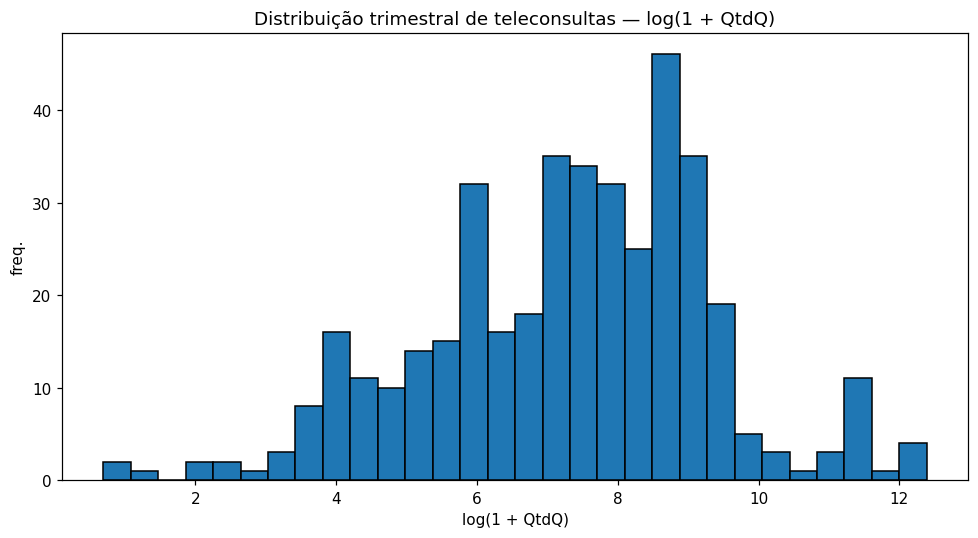

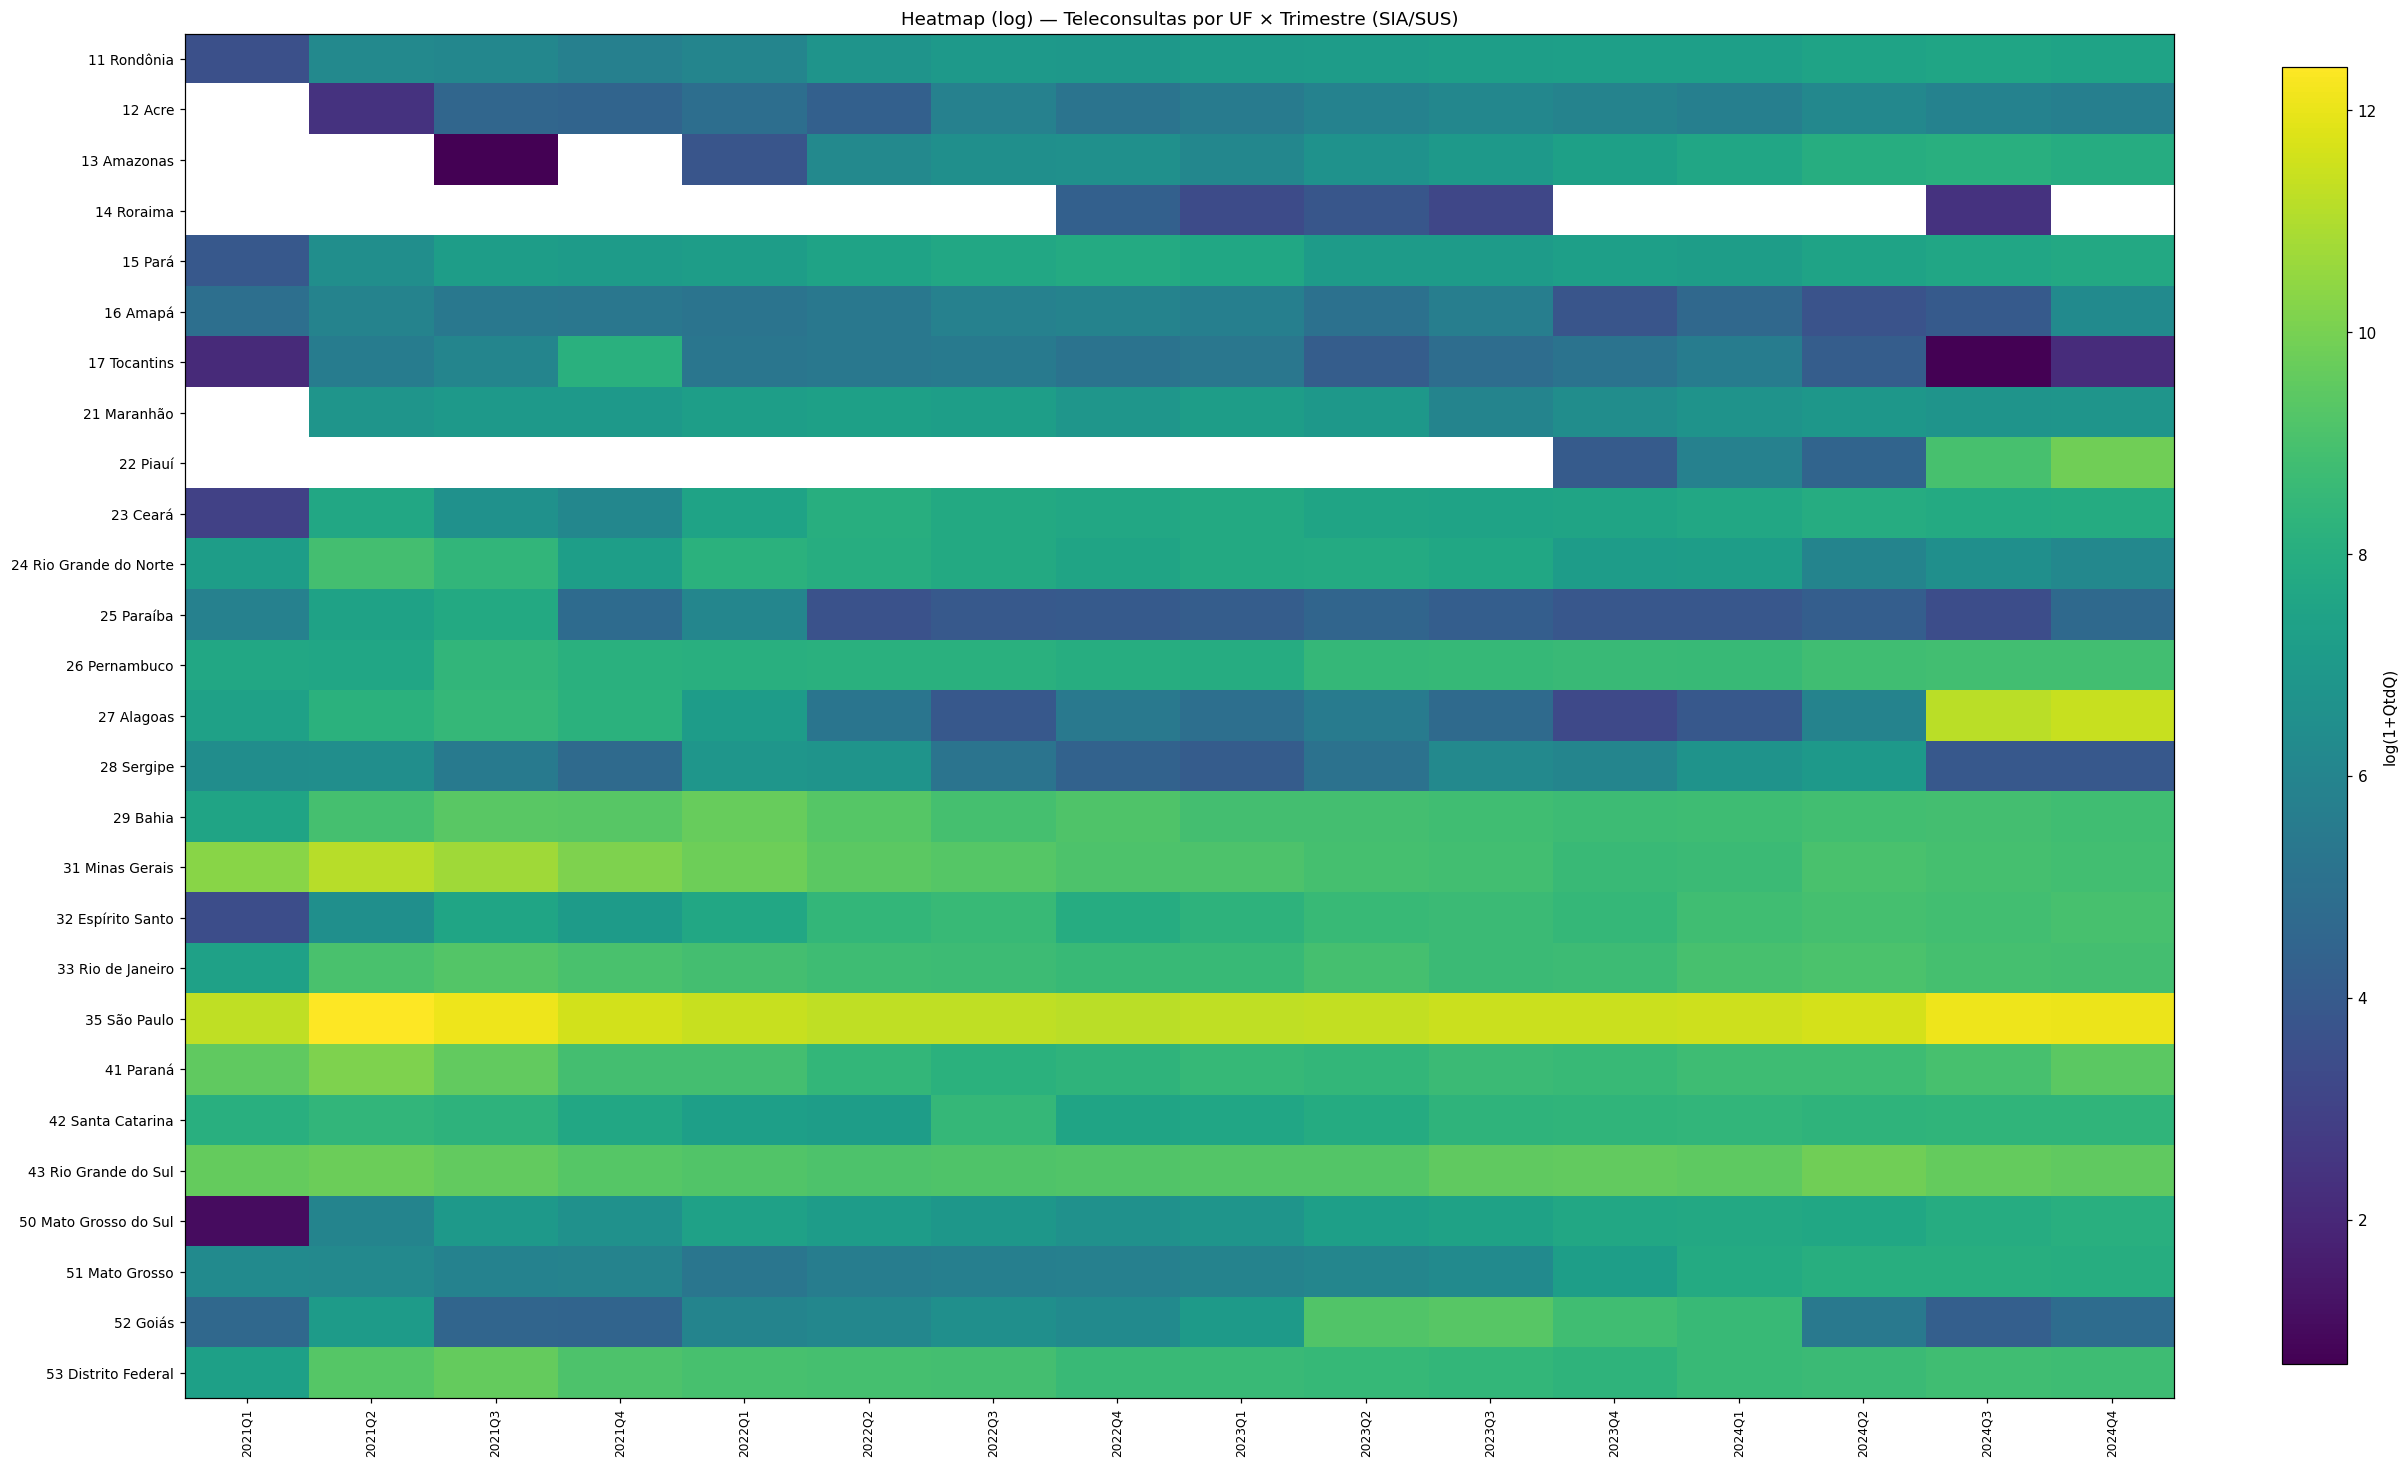

Período de trimestres: 2021Q1 → 2024Q4


In [17]:
# B3 — EDA trimestral (histograma + heatmap)  ✅
# Usa log1p para melhorar contraste (dados muito assimétricos)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(9,5))
plt.hist(np.log1p(df_q["QtdQ"]), bins=30, edgecolor="black")
plt.title("Distribuição trimestral de teleconsultas — log(1 + QtdQ)")
plt.xlabel("log(1 + QtdQ)"); plt.ylabel("freq.")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/dist_qtdq_log.png"); plt.show()

order_cols = df_q["YearQuarter"].drop_duplicates().tolist()
pv = df_q.pivot_table(index="UF", columns="YearQuarter", values="QtdQ", aggfunc="sum").reindex(columns=order_cols)

plt.figure(figsize=(min(1.0*pv.shape[1]+6, 24), min(0.35*pv.shape[0]+4, 18)))
im = plt.imshow(np.log1p(pv.values), aspect="auto", cmap="viridis")
plt.colorbar(im, fraction=0.03, label="log(1+QtdQ)")
plt.xticks(range(pv.shape[1]), pv.columns, rotation=90, fontsize=8)
plt.yticks(range(pv.shape[0]), pv.index, fontsize=9)
plt.title("Heatmap (log) — Teleconsultas por UF × Trimestre (SIA/SUS)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/heatmap_uf_trim.png"); plt.show()

print("Período de trimestres:", pv.columns.min(), "→", pv.columns.max())


In [18]:
# B4 — Alvo (classe) por trimestre: top 25% (alta adoção = 1)  ✅
def _top25(g):
    thr = g["QtdQ"].quantile(0.75)
    return (g["QtdQ"] >= thr).astype(int)

df_q = df_q.copy()
df_q["target_high"] = df_q.groupby("YearQuarter", group_keys=False).apply(_top25)
balance = (df_q["target_high"].value_counts(normalize=True)*100).round(2).rename({0:"baixa",1:"alta"})
print("Balanceamento do alvo (esperado ~25% alta):")
display(balance)


Balanceamento do alvo (esperado ~25% alta):


target_high
baixa    73.09
alta     26.91
Name: proportion, dtype: float64

In [19]:
# B5 — Feature engineering: lags/delta/média móvel + sazonalidade  ✅
import numpy as np

df_q = df_q.sort_values(["UF","q_index"]).reset_index(drop=True)

gb = df_q.groupby("UF", group_keys=False)
df_q["lag1"]  = gb["QtdQ"].shift(1)
df_q["delta"] = df_q["QtdQ"] - df_q["lag1"]
df_q["ma2"]   = gb["QtdQ"].rolling(2).mean().reset_index(level=0, drop=True)

# quarter num (1..4) a partir de YearQuarter
df_q["quarter_num"] = df_q["YearQuarter"].str.extract(r"Q([1-4])").astype(int)
df_q["q_sin"] = np.sin(2*np.pi*df_q["quarter_num"]/4)
df_q["q_cos"] = np.cos(2*np.pi*df_q["quarter_num"]/4)

# remove primeiras linhas sem lag/ma
df_model = df_q.dropna(subset=["lag1","ma2"]).copy()

num_feats = ["QtdQ","lag1","delta","ma2","q_sin","q_cos"]
cat_feats = ["UF"]

X = df_model[num_feats + cat_feats + ["q_index","YearQuarter"]].copy()
y = df_model["target_high"].astype(int).copy()

print("Formas — X:", X.shape, "| y:", y.shape, "| trimestres únicos:", df_model["YearQuarter"].nunique())


Formas — X: (378, 9) | y: (378,) | trimestres únicos: 15


In [20]:
# B6 — Split temporal + pipeline de pré-processamento  ✅
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

last_q = df_model["q_index"].max()
train_mask = X["q_index"] < last_q
test_mask  = X["q_index"] == last_q

X_train = X.loc[train_mask].drop(columns=["q_index","YearQuarter"])
X_test  = X.loc[test_mask].drop(columns=["q_index","YearQuarter"])
y_train = y.loc[train_mask]
y_test  = y.loc[test_mask]

print("Trimestre de TESTE:", df_model.loc[test_mask, "YearQuarter"].unique())

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])

# Compatibilidade scikit-learn (sparse_output em versões novas)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  ohe)])

pre = ColumnTransformer([("num", num_pipe, num_feats),
                         ("cat", cat_pipe, cat_feats)])

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


Trimestre de TESTE: ['2024Q4']
X_train: (352, 7) | X_test: (26, 7)


In [21]:
# B7 — GridSearchCV com Regressão Logística (L1/L2, C) + avaliação no teste  ✅
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)

logreg = LogisticRegression(solver="liblinear", max_iter=4000, random_state=42)
pipe_lr = Pipeline([("pre", pre), ("clf", logreg)])

# CV por grupos (trimestre) no treino
n_groups = np.unique(df_model.loc[train_mask, "q_index"]).size
n_splits = max(2, min(5, n_groups))  # garante >=2
cv = GroupKFold(n_splits=n_splits)
groups = df_model.loc[train_mask, "q_index"].values

grid = GridSearchCV(
    pipe_lr,
    param_grid={"clf__penalty": ["l1","l2"], "clf__C": [0.01, 0.1, 1, 10]},
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
).fit(X_train, y_train, **{"groups": groups})

best_lr = grid.best_estimator_
print("Melhores params (LogReg):", grid.best_params_, "| F1 médio CV:", round(grid.best_score_, 4))

# Avaliação no último trimestre (generalização temporal)
y_pred  = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)
cm   = confusion_matrix(y_test, y_pred)

print(f"LOGREG — TESTE: Acc {acc:.4f} | F1 {f1:.4f} | Prec {prec:.4f} | Rec {rec:.4f} | ROC AUC {auc:.4f}")
print("Matriz de confusão:\n", cm)


Melhores params (LogReg): {'clf__C': 10, 'clf__penalty': 'l2'} | F1 médio CV: 0.9024
LOGREG — TESTE: Acc 0.8846 | F1 0.8235 | Prec 0.7000 | Rec 1.0000 | ROC AUC 0.9925
Matriz de confusão:
 [[16  3]
 [ 0  7]]


In [22]:
# B8 — Modelo de comparação: Gradient Boosting (pequeno grid)  ✅
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb_pipe = Pipeline([("pre", pre), ("clf", GradientBoostingClassifier(random_state=42))])
gb_grid = {"clf__n_estimators":[100,200],
           "clf__learning_rate":[0.05,0.1],
           "clf__max_depth":[2,3]}

gb_cv = GridSearchCV(gb_pipe, gb_grid, scoring="f1", cv=cv, n_jobs=-1, refit=True)
gb_cv.fit(X_train, y_train, **{"groups": groups})
gb_best = gb_cv.best_estimator_

gb_pred  = gb_best.predict(X_test)
gb_proba = gb_best.predict_proba(X_test)[:,1]
gb_acc = accuracy_score(y_test, gb_pred)
gb_f1  = f1_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_proba)

print("GB — melhores params:", gb_cv.best_params_, "| F1 CV:", round(gb_cv.best_score_,4))
print(f"GB — TESTE: Acc {gb_acc:.4f} | F1 {gb_f1:.4f} | ROC AUC {gb_auc:.4f}")


GB — melhores params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 200} | F1 CV: 0.8992
GB — TESTE: Acc 0.8462 | F1 0.7778 | ROC AUC 1.0000


,feature,coef,abs_coef
0,num__QtdQ,5.959295,5.959295
3,num__ma2,5.425067,5.425067
1,num__lag1,4.512395,4.512395
24,cat__UF_33 Rio de Janeiro,4.007520,4.007520
2,num__delta,3.656314,3.656314
22,cat__UF_31 Minas Gerais,3.348850,3.348850
28,cat__UF_43 Rio Grande do Sul,1.936788,1.936788
16,cat__UF_24 Rio Grande do Norte,-1.827139,1.827139
27,cat__UF_42 Santa Catarina,-1.779955,1.779955
23,cat__UF_32 Espírito Santo,1.620680,1.620680


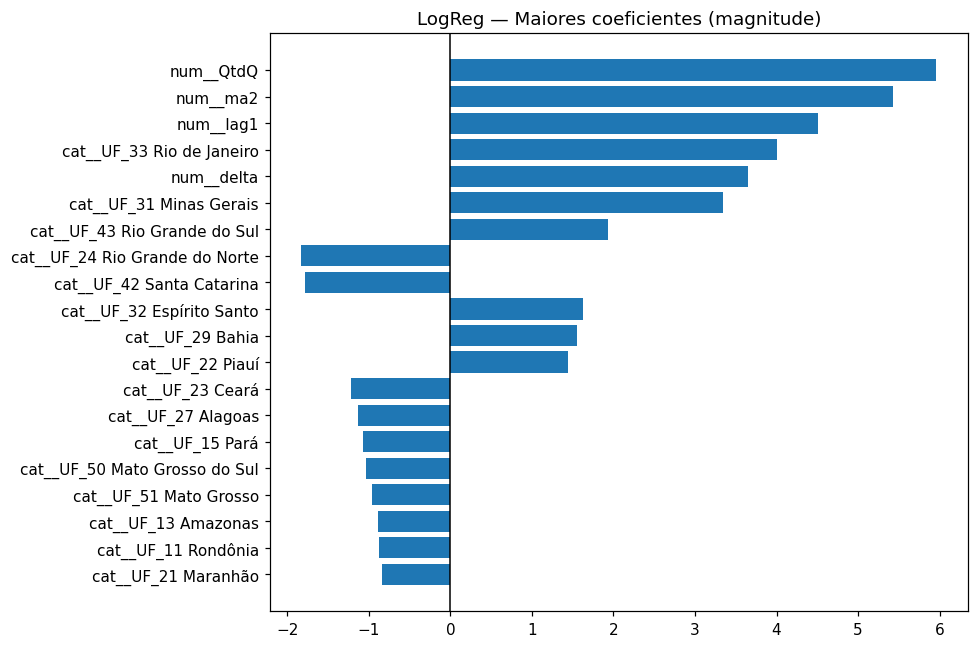

In [23]:
# B9 — Interpretação rápida: top coeficientes (LogReg) + gráfico  ✅
import pandas as pd
import matplotlib.pyplot as plt

feat_names = best_lr.named_steps["pre"].get_feature_names_out()
coefs = best_lr.named_steps["clf"].coef_.ravel()

coefs_df = (pd.DataFrame({"feature": feat_names, "coef": coefs})
              .assign(abs_coef=lambda d: d["coef"].abs())
              .sort_values("abs_coef", ascending=False)
              .head(20))

display(coefs_df)

plt.figure(figsize=(9,6))
plt.barh(coefs_df["feature"], coefs_df["coef"])
plt.axvline(0, color="k", lw=1); plt.gca().invert_yaxis()
plt.title("LogReg — Maiores coeficientes (magnitude)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/coef_logreg_top20.png"); plt.show()


In [24]:
# B10 — Artefatos para o projeto + resumo para o PDF  ✅
import os, json
import pandas as pd

# CSV com predições do trimestre mais recente (para API/app)
qt_test = X.loc[test_mask, "YearQuarter"].iloc[0]
pred_df = pd.DataFrame({
    "UF": X.loc[test_mask, "UF"].values,
    "YearQuarter": qt_test,
    "y_true": y_test.values,
    "proba_alta": y_proba,
    "classe_predita": best_lr.predict(X_test)
})
pred_path = f"{OUTDIR}/predicoes_{qt_test}.csv"
pred_df.to_csv(pred_path, index=False)

# Salva métricas em JSON (LogReg e GB)
metrics = {
    "logreg": {
        "best_params": grid.best_params_,
        "cv_f1_mean": float(grid.best_score_),
        "test": {"acc": float(acc), "f1": float(f1), "prec": float(prec),
                 "rec": float(rec), "auc": float(auc), "cm": cm.tolist()}
    },
    "gb": {
        "best_params": gb_cv.best_params_,
        "cv_f1_mean": float(gb_cv.best_score_),
        "test": {"acc": float(gb_acc), "f1": float(gb_f1), "auc": float(gb_auc)}
    }
}
json.dump(metrics, open(f"{OUTDIR}/metrics.json","w"), indent=2)

print("\n==== RESUMO PARA O RELATÓRIO ====")
print("Problema: Classificar UF × Trimestre como Alta (top 25%) vs Baixa adoção de teleconsulta (SIA/SUS).")
print("Alvo: top 25% de QtdQ dentro de cada trimestre (comparação justa no tempo).")
print("Validação: split temporal (treino nos trimestres anteriores, teste no último); CV por grupos (trimestre) no treino.")
print("\nLogReg —", metrics["logreg"]["best_params"], "| F1 CV:", round(metrics["logreg"]["cv_f1_mean"],4))
print("TESTE — Acc {a:.4f} | F1 {f:.4f} | Prec {p:.4f} | Rec {r:.4f} | AUC {u:.4f}"
      .format(a=metrics["logreg"]["test"]["acc"], f=metrics["logreg"]["test"]["f1"],
              p=metrics["logreg"]["test"]["prec"], r=metrics["logreg"]["test"]["rec"],
              u=metrics["logreg"]["test"]["auc"]))
print("Matriz:", metrics["logreg"]["test"]["cm"])
print("\nGB —", metrics["gb"]["best_params"], "| F1 CV:", round(metrics["gb"]["cv_f1_mean"],4))
print("GB TESTE — Acc {a:.4f} | F1 {f:.4f} | AUC {u:.4f}".format(a=metrics["gb"]["test"]["acc"],
                                                                  f=metrics["gb"]["test"]["f1"],
                                                                  u=metrics["gb"]["test"]["auc"]))
print("\nFiguras salvas em:", os.path.abspath(OUTDIR))
print("Predições para o app/API:", pred_path)



==== RESUMO PARA O RELATÓRIO ====
Problema: Classificar UF × Trimestre como Alta (top 25%) vs Baixa adoção de teleconsulta (SIA/SUS).
Alvo: top 25% de QtdQ dentro de cada trimestre (comparação justa no tempo).
Validação: split temporal (treino nos trimestres anteriores, teste no último); CV por grupos (trimestre) no treino.

LogReg — {'clf__C': 10, 'clf__penalty': 'l2'} | F1 CV: 0.9024
TESTE — Acc 0.8846 | F1 0.8235 | Prec 0.7000 | Rec 1.0000 | AUC 0.9925
Matriz: [[16, 3], [0, 7]]

GB — {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 200} | F1 CV: 0.8992
GB TESTE — Acc 0.8462 | F1 0.7778 | AUC 1.0000

Figuras salvas em: c:\Users\pedro\OneDrive\Área de Trabalho\2GS2025\IA-CHALL\outputs
Predições para o app/API: ./outputs/predicoes_2024Q4.csv
